In [2]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])

import random
#from pyswarm import pso
import isocor

In [3]:
#sns.set_theme(style="ticks", palette="pastel")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [4]:
element_prob_dict = {
    'N_natural': 0.00364,
    'N_enriched': 0.997774
}

In [5]:
def RR2Asp(RR):
    return(54.611* (RR**1.0578))
def RR2Asn(RR):
    return(60.033* (RR**0.9177))

In [6]:
Sample_names = ['HU01','HU02','HU03','HU04','HU05','HU06']
conc = [10, 20, 30, 40, 50, 60]
annotation_df = pd.DataFrame(list(zip(Sample_names, conc)), columns =['Sample_name', 'Conc'])

In [7]:
### Read measurements

### Replace all N/F with 0 before start ###
#esheet_dict_mes = pd.read_excel('Uridine-Hypoxanthine_salvage_143B-Nuc-RFP-noArgP10.xlsx', sheet_name=None)
esheet_dict_mes = pd.read_excel('Uridine-Hypoxanthine_salvage_H1299.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        ### Turned off
        if sum(metab_dict_mes[k]['Response Ratio']) != 0 and False:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'ISTD Response', 'Flag Details'], axis=1)

In [8]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']

In [9]:
metab_to_correct = {
    'Glutamine pos': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C5H11N2O3',
        'tracer_element': '15N',
        'charge': 1
    },
    'Asparagine pos': {
        'Nmes': 1,
        'Niso': 2,
        'ion_formula': 'C4H9N2O3',
        'tracer_element': '15N',
        'charge': 1
    },
    # AMP = C10H14N5O7P
    # Derived from:
    # 1. Hpx salvage (2x natural abundance N) + 3x natural abundance N (from 2xAsp and Gly)
    # 2. 2x Gln + 3x natural abundance N (from 2xAsp and Gly)
    'AMP pos': {
        'Nmes': 2,
        'Niso': 5,
        'ion_formula': 'C10H15N5O7P',
        'tracer_element': '15N',
        'charge': 1
    },
    'ADP neg': {
        'Nmes': 2,
        'Niso': 5,
        'ion_formula': 'C10H14N5O10P2',
        'tracer_element': '15N',
        'charge': -1
    },
    # UMP = C9H13N2O9P
    # Derived from:
    # 1. Uridine salvage (2x natural abundance N)
    # 2. 1x Gln + 1x natural abundance N (from Asp)
    'UMP neg': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C9H12N2O9P',
        'tracer_element': '15N',
        'charge': -1
    },
    'UDP neg': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C9H13N2O12P2',
        'tracer_element': '15N',
        'charge': -1
    },
    # GMP = C10H14N5O8P
    # Derived from:
    # 1. Hpx salvage (2x natural abundance N) + 1x Gln + 2x natural abundance N (from Asp and Gly)
    # 2. 3x Gln + 2x natural abundance N (from Asp and Gly)
    'GMP pos': {
        'Nmes': 3,
        'Niso': 5,
        'ion_formula': 'C10H15N5O8P',
        'tracer_element': '15N',
        'charge': 1
    },
    'GDP neg': {
        'Nmes': 3,
        'Niso': 5,
        'ion_formula': 'C10H14N5O11P2',
        'tracer_element': '15N',
        'charge': 1
    },
    # CMP = C9H14N3O8P
    # Derived from:
    # 1. Ur salvage (2x natural abundance N) + 1x Gln
    # 2. 2x Gln + 1x natural abundance N (from Asp)
    'CMP neg': {
        'Nmes': 3,
        'Niso': 3,
        'ion_formula': 'C9H13N3O8P',
        'tracer_element': '15N',
        'charge': -1
    },
    'CDP neg': {
        'Nmes': 3,
        'Niso': 3,
        'ion_formula': 'C9H14N3O11P2',
        'tracer_element': '15N',
        'charge': -1
    }
}

In [9]:
tracer_purity = {'15N': [1-element_prob_dict['N_enriched'], element_prob_dict['N_enriched']]}
for metab in metab_to_correct.keys():
    ion_formula = metab_to_correct[metab]['ion_formula']
    charge = metab_to_correct[metab]['charge']
    tracer_element = metab_to_correct[metab]['tracer_element']
    metab_name, polarity = metab.split()
    Nmes1 = metab_to_correct[metab]['Nmes']+1
    
    corrector_HR = isocor.mscorrectors.MetaboliteCorrectorFactory(formula=ion_formula, label=metab_name, tracer=tracer_element, tracer_purity=tracer_purity[tracer_element], resolution=240000, mz_of_resolution=200, charge=charge, correct_NA_tracer=True, resolution_formula_code='orbitrap')

    ratios = {'{} 15N{} ratio'.format(metab_name, i):[] for i in range(Nmes1)}
    for sample_idx in range(6):
        obs_mid = []
        for i in range(metab_to_correct[metab]['Niso']+1):
            if i == 0:
                obs_mid.append(df['{} {}'.format(metab_name, polarity)].values[sample_idx])
            elif i <= metab_to_correct[metab]['Nmes']:
                obs_mid.append(df['{} 15N{} {}'.format(metab_name, i, polarity)].values[sample_idx])
            else:
                obs_mid.append(0)
        
        # Calculate the corrected isotope fraction:
        corrected_area, iso_fraction, res, m_enr = corrector_HR.correct(obs_mid)
        iso_fraction_norm = iso_fraction[0:Nmes1] / sum(iso_fraction[0:Nmes1])
        for i in range(Nmes1):
            ratios['{} 15N{} ratio'.format(metab_name, i)].append(iso_fraction_norm[i])
        
    for colname in ratios.keys():
        df[colname] = ratios[colname]
    


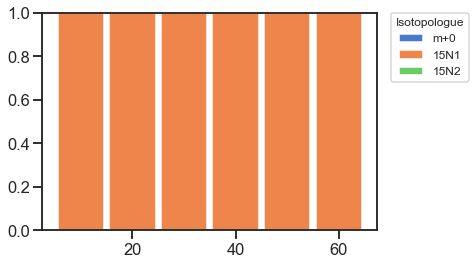

In [10]:
isotopologues = ['m+0', '15N1', '15N2']
r = df['Conc'].values
bars = df['Glutamine 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['Glutamine 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['Glutamine 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

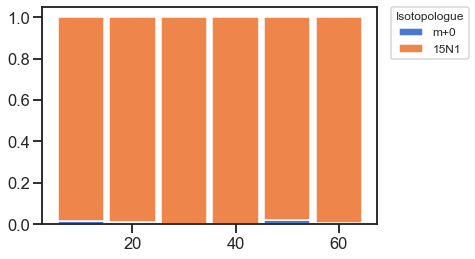

In [11]:
isotopologues = ['m+0', '15N1']
r = df['Conc'].values
bars = df['Asparagine 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['Asparagine 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

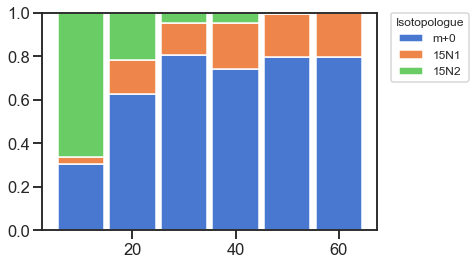

In [12]:
isotopologues = ['m+0', '15N1', '15N2']
r = df['Conc'].values
bars = df['AMP 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['AMP 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['AMP 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

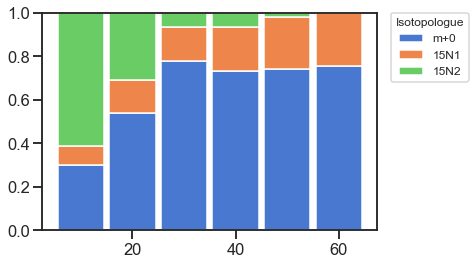

In [13]:
isotopologues = ['m+0', '15N1', '15N2']
r = df['Conc'].values
bars = df['ADP 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['ADP 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['ADP 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

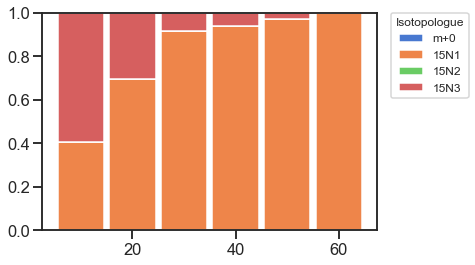

In [14]:
isotopologues = ['m+0', '15N1', '15N2', '15N3']
r = df['Conc'].values
bars = df['GMP 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['GMP 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['GMP 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['GMP 15N3 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

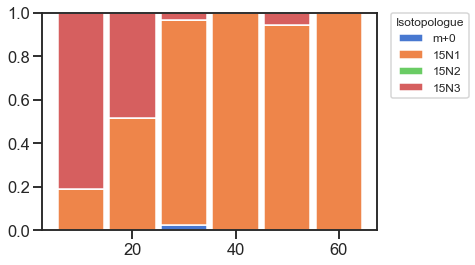

In [15]:
isotopologues = ['m+0', '15N1', '15N2', '15N3']
r = df['Conc'].values
bars = df['GDP 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['GDP 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['GDP 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['GDP 15N3 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

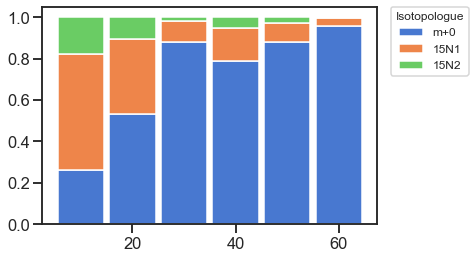

In [16]:
isotopologues = ['m+0', '15N1', '15N2']
r = df['Conc'].values
bars = df['UMP 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['UMP 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['UMP 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

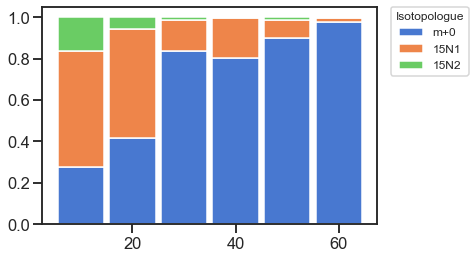

In [17]:
isotopologues = ['m+0', '15N1', '15N2']
r = df['Conc'].values
bars = df['UDP 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['UDP 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['UDP 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

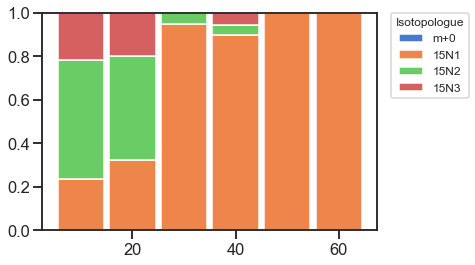

In [18]:
isotopologues = ['m+0', '15N1', '15N2', '15N3']
r = df['Conc'].values
bars = df['CMP 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['CMP 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['CMP 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['CMP 15N3 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

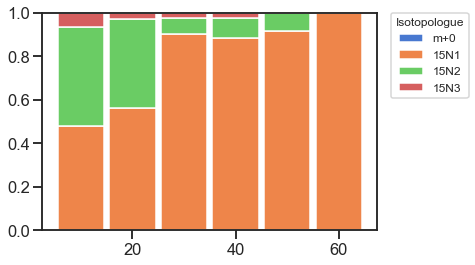

In [19]:
isotopologues = ['m+0', '15N1', '15N2', '15N3']
r = df['Conc'].values
bars = df['CDP 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df['CDP 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['CDP 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df['CDP 15N3 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

In [20]:
#### Impute salvage fraction ####

In [25]:
sal_data = dict()

for base in ['AMP', 'ADP', 'GMP', 'GDP', 'UMP', 'UDP', 'CMP', 'CDP']:
#for base in ['CMP', 'CDP']:
    sal_data[base] = list()
    for i in range(6):
        if base[0] == 'A':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values[i]*100,
            1: df['{} 15N1 ratio'.format(base)].values[i]*100,
            2: df['{} 15N2 ratio'.format(base)].values[i]*100
            }

            # Save imputed salvage fraction:
            # m+0 = salvage, m+2 = de novo synthesis
            sal_data[base].append(obs_data[0] / sum([obs_data[0], obs_data[2]]))

        if base[0] == 'U':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values[i]*100,
            1: df['{} 15N1 ratio'.format(base)].values[i]*100,
            2: df['{} 15N2 ratio'.format(base)].values[i]*100
            }
            
            # Save imputed salvage fraction:
            # m+0 = salvage, m+1 = de novo synthesis
            sal_data[base].append(obs_data[0] / sum([obs_data[0], obs_data[1]]))

        if base[0] == 'G':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values[i]*100,
            1: df['{} 15N1 ratio'.format(base)].values[i]*100,
            2: df['{} 15N2 ratio'.format(base)].values[i]*100,
            3: df['{} 15N3 ratio'.format(base)].values[i]*100
            }
            
            # Save imputed salvage fraction:
            # m+1 = salvage, m+3 = de novo synthesis
            sal_data[base].append(obs_data[1] / sum([obs_data[1], obs_data[3]]))

        if base[0] == 'C':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values[i]*100,
            1: df['{} 15N1 ratio'.format(base)].values[i]*100,
            2: df['{} 15N2 ratio'.format(base)].values[i]*100,
            3: df['{} 15N3 ratio'.format(base)].values[i]*100
            }

            # Save imputed salvage fraction:
            # m+1 = salvage, m+2 = de novo synthesis
            sal_data[base].append(obs_data[1] / sum([obs_data[1], obs_data[2]]))

In [26]:
sal_data['Conc'] = [10, 20, 30, 40, 50, 60]
df_imputed = pd.DataFrame(sal_data)
df_imputed_flat = pd.melt(df_imputed, id_vars=['Conc'])
df_imputed_flat = df_imputed_flat.rename(columns={'variable': 'Nucleotide', 'value': 'Salvage fraction'})
df_imputed_flat['Type'] = ['Purine' if base[0] == 'A' or base[0] == 'G' else 'Pyrimidine' for base in df_imputed_flat['Nucleotide']]
df_imputed_flat['Charge'] = ['Monophosphate' if base[1] == 'M' else 'Diphosphate' for base in df_imputed_flat['Nucleotide']]

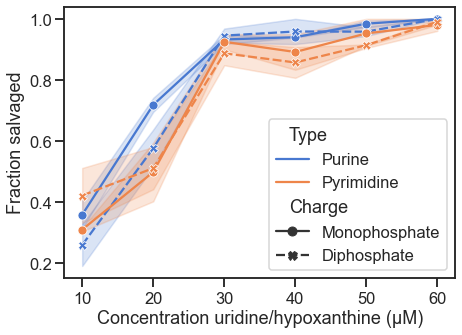

In [30]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("Uridine-Hypoxanthine_salvage-fraction_143B-Nuc-RFP-noArgP10.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages("Uridine-Hypoxanthine_salvage-fraction_H1299.pdf")
fig = plt.figure(figsize=(7, 5))

sns.lineplot(data=df_imputed_flat, x='Conc', y='Salvage fraction', hue='Type', style='Charge', markers=True, dashes=True);

plt.ylabel('Fraction salvaged')#, size=12);
plt.xlabel('Concentration uridine/hypoxanthine (μM)')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

In [10]:
def read_data(fnam, metab_to_correct):
    
    Sample_names = ['HU01','HU02','HU03','HU04','HU05','HU06']
    conc = [10, 20, 30, 40, 50, 60]
    annotation_df = pd.DataFrame(list(zip(Sample_names, conc)), columns =['Sample_name', 'Conc'])


    ### Read measurements

    ### Replace all N/F with 0 before start ###
    #esheet_dict_mes = pd.read_excel('Uridine-Hypoxanthine_salvage_143B-Nuc-RFP-noArgP10.xlsx', sheet_name=None)
    #esheet_dict_mes = pd.read_excel('Uridine-Hypoxanthine_salvage_H1299.xlsx', sheet_name=None)
    esheet_dict_mes = pd.read_excel(fnam, sheet_name=None)

    metab_dict_mes = dict()
    metab_names_mes = list()
    for k in esheet_dict_mes.keys():
        if 'U-13C' not in k:
            metab_names_mes.append(k)
            metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
            # If internal standard use response ratio:
            ### Turned off
            if sum(metab_dict_mes[k]['Response Ratio']) != 0 and False:
                metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
            metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]

            # Add annotations:
            metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
            metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'ISTD Response', 'Flag Details'], axis=1)



    df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
    for nam in metab_names_mes:
        assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
        df[nam] = metab_dict_mes[nam]['Response']



    tracer_purity = {'15N': [1-element_prob_dict['N_enriched'], element_prob_dict['N_enriched']]}
    for metab in metab_to_correct.keys():
        ion_formula = metab_to_correct[metab]['ion_formula']
        charge = metab_to_correct[metab]['charge']
        tracer_element = metab_to_correct[metab]['tracer_element']
        metab_name, polarity = metab.split()
        Nmes1 = metab_to_correct[metab]['Nmes']+1

        corrector_HR = isocor.mscorrectors.MetaboliteCorrectorFactory(formula=ion_formula, label=metab_name, tracer=tracer_element, tracer_purity=tracer_purity[tracer_element], resolution=240000, mz_of_resolution=200, charge=charge, correct_NA_tracer=True, resolution_formula_code='orbitrap')

        ratios = {'{} 15N{} ratio'.format(metab_name, i):[] for i in range(Nmes1)}
        for sample_idx in range(6):
            obs_mid = []
            for i in range(metab_to_correct[metab]['Niso']+1):
                if i == 0:
                    obs_mid.append(df['{} {}'.format(metab_name, polarity)].values[sample_idx])
                elif i <= metab_to_correct[metab]['Nmes']:
                    obs_mid.append(df['{} 15N{} {}'.format(metab_name, i, polarity)].values[sample_idx])
                else:
                    obs_mid.append(0)

            # Calculate the corrected isotope fraction:
            corrected_area, iso_fraction, res, m_enr = corrector_HR.correct(obs_mid)
            iso_fraction_norm = iso_fraction[0:Nmes1] / sum(iso_fraction[0:Nmes1])
            for i in range(Nmes1):
                ratios['{} 15N{} ratio'.format(metab_name, i)].append(iso_fraction_norm[i])

        for colname in ratios.keys():
            df[colname] = ratios[colname]



    sal_data = dict()

    for base in ['AMP', 'ADP', 'GMP', 'GDP', 'UMP', 'UDP', 'CMP', 'CDP']:
    #for base in ['CMP', 'CDP']:
        sal_data[base] = list()
        for i in range(6):
            if base[0] == 'A':
                obs_data = {
                0: df['{} 15N0 ratio'.format(base)].values[i]*100,
                1: df['{} 15N1 ratio'.format(base)].values[i]*100,
                2: df['{} 15N2 ratio'.format(base)].values[i]*100
                }

                # Save imputed salvage fraction:
                # m+0 = salvage, m+2 = de novo synthesis
                sal_data[base].append(obs_data[0] / sum([obs_data[0], obs_data[2]]))

            if base[0] == 'U':
                obs_data = {
                0: df['{} 15N0 ratio'.format(base)].values[i]*100,
                1: df['{} 15N1 ratio'.format(base)].values[i]*100,
                2: df['{} 15N2 ratio'.format(base)].values[i]*100
                }

                # Save imputed salvage fraction:
                # m+0 = salvage, m+1 = de novo synthesis
                sal_data[base].append(obs_data[0] / sum([obs_data[0], obs_data[1]]))

            if base[0] == 'G':
                obs_data = {
                0: df['{} 15N0 ratio'.format(base)].values[i]*100,
                1: df['{} 15N1 ratio'.format(base)].values[i]*100,
                2: df['{} 15N2 ratio'.format(base)].values[i]*100,
                3: df['{} 15N3 ratio'.format(base)].values[i]*100
                }

                # Save imputed salvage fraction:
                # m+1 = salvage, m+3 = de novo synthesis
                sal_data[base].append(obs_data[1] / sum([obs_data[1], obs_data[3]]))

            if base[0] == 'C':
                obs_data = {
                0: df['{} 15N0 ratio'.format(base)].values[i]*100,
                1: df['{} 15N1 ratio'.format(base)].values[i]*100,
                2: df['{} 15N2 ratio'.format(base)].values[i]*100,
                3: df['{} 15N3 ratio'.format(base)].values[i]*100
                }

                # Save imputed salvage fraction:
                # m+1 = salvage, m+2 = de novo synthesis
                sal_data[base].append(obs_data[1] / sum([obs_data[1], obs_data[2]]))



    sal_data['Conc'] = [10, 20, 30, 40, 50, 60]
    df_imputed = pd.DataFrame(sal_data)
    df_imputed_flat = pd.melt(df_imputed, id_vars=['Conc'])
    df_imputed_flat = df_imputed_flat.rename(columns={'variable': 'Nucleotide', 'value': 'Salvage fraction'})
    df_imputed_flat['Type'] = ['Purine' if base[0] == 'A' or base[0] == 'G' else 'Pyrimidine' for base in df_imputed_flat['Nucleotide']]
    df_imputed_flat['Charge'] = ['Monophosphate' if base[1] == 'M' else 'Diphosphate' for base in df_imputed_flat['Nucleotide']]





    return(df_imputed_flat)

In [11]:
df_143B = read_data('Uridine-Hypoxanthine_salvage_143B-Nuc-RFP-noArgP10.xlsx', metab_to_correct)
df_H1299 = read_data('Uridine-Hypoxanthine_salvage_H1299.xlsx', metab_to_correct)

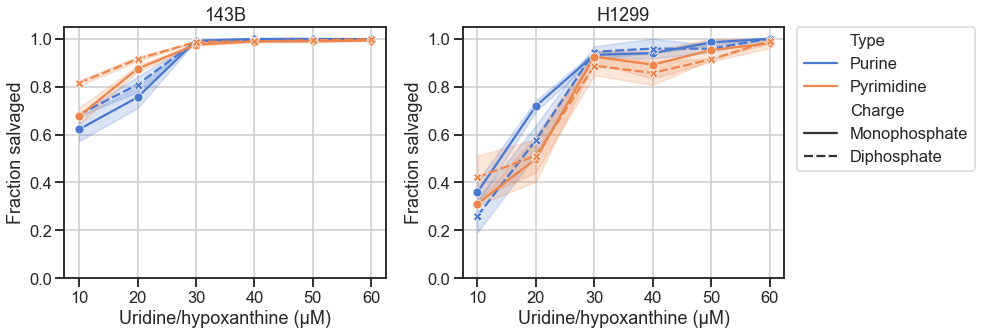

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

g1 = sns.lineplot(ax=ax1, data=df_143B, x='Conc', y='Salvage fraction', hue='Type', style='Charge', markers=True, dashes=True)

g1.grid(True)
g1.set_ylim([0, 1.05])
g1.set_ylabel('Fraction salvaged');
g1.set_xlabel('Uridine/hypoxanthine (μM)');
g1.set_title('143B')
g1.legend_.remove()



g2 = sns.lineplot(ax=ax2, data=df_H1299, x='Conc', y='Salvage fraction', hue='Type', style='Charge', markers=True, dashes=True)

g2.grid(True)
g2.set_ylim([0, 1.05])
g2.set_ylabel('Fraction salvaged');
g2.set_xlabel('Uridine/hypoxanthine (μM)');
g2.set_title('H1299')

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, ncol=1)


plt.tight_layout()
fig.savefig('Uridine-Hypoxanthine_salvage-fraction_combined.pdf')

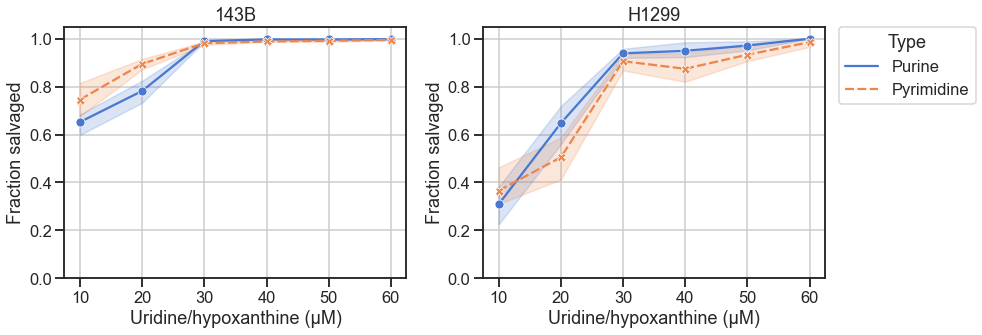

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

g1 = sns.lineplot(ax=ax1, data=df_143B, x='Conc', y='Salvage fraction', hue='Type', style='Type', markers=True, dashes=True)

g1.grid(True)
g1.set_ylim([0, 1.05])
g1.set_ylabel('Fraction salvaged');
g1.set_xlabel('Uridine/hypoxanthine (μM)');
g1.set_title('143B')
g1.legend_.remove()



g2 = sns.lineplot(ax=ax2, data=df_H1299, x='Conc', y='Salvage fraction', hue='Type', style='Type', markers=True, dashes=True)

g2.grid(True)
g2.set_ylim([0, 1.05])
g2.set_ylabel('Fraction salvaged');
g2.set_xlabel('Uridine/hypoxanthine (μM)');
g2.set_title('H1299')

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, ncol=1)


plt.tight_layout()
fig.savefig('Uridine-Hypoxanthine_salvage-fraction_combined_no-charge.pdf')